a bad map

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from osmnx import features_from_bbox
import pandas as pd
import requests
from shapely import Point
from shapely.geometry import shape

In [2]:
##################### get greater london boundary from open street map
search = 'Greater London'
nominatim = 'https://nominatim.openstreetmap.org/search?'
qry=f'q={search.replace(" ","+")}'
url = f'{nominatim}{qry}&polygon_geojson=1&format=geojson'
response = requests.get(url)
data = response.json()
boundary = gpd.GeoDataFrame(geometry=[shape(f['geometry']) for f in data['features']],
                            crs=4326)

west, south, east, north = boundary.total_bounds
boundary = boundary.to_crs(27700) # reproject

In [3]:
##################### use osmnx to get features from open street map
##################### get point features for hosptials, and party/firework shops in greater london
points = features_from_bbox(north=north,
                            south=south,
                            east=east,
                            west=west,
                            tags={'shop':['party','pyrotechnics'],
                                  'amenity':'hospital'})

points = points.reset_index()
points = points.loc[points['element_type']=='node'].copy()

##################### add new column (venue) and merge fireworks/pyrotechnics into one category
points['venue'] = pd.Series()
points.loc[points['amenity'] == 'hospital', 'venue'] = 'hospital'
points.loc[points['shop'].isin(['party','pyrotechnics']), 'venue'] = 'fireworks/party shop'

points = points.to_crs(27700).clip(boundary)

##################### get the River Thames
river = features_from_bbox(north=north,
                          south=south,
                          east=east,
                          west=west,
                          tags={'name':'River Thames'})
river = river.to_crs(27700)

##################### and the main road network
roads = features_from_bbox(north=north,
                          south=south,
                          east=east,
                          west=west,
                          tags={'highway':['primary','secondary','tertiary']})

roads = roads.dissolve('highway').reset_index().to_crs(27700)

C:\Users\s1759665\AppData\Local\Temp\ipykernel_17888\849275526.py:94: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
c:\Users\s1759665\Miniconda3\envs\shadow\Lib\site-packages\pyproj\transformer.py:812: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


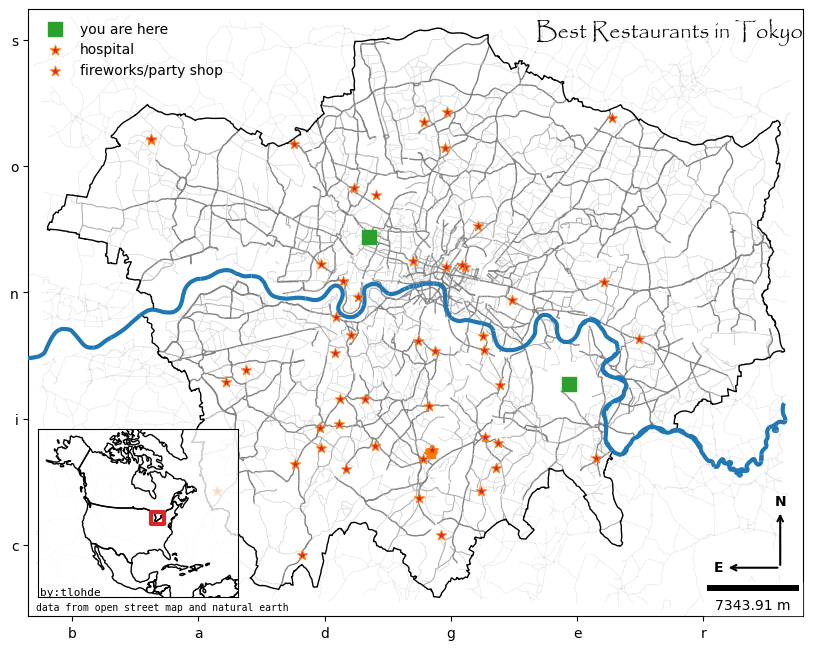

In [5]:
##################### plotting
fig, ax = plt.subplots(figsize=[10,10])

##################### add roads - varying width and colour
for a,b,c in zip(['primary','secondary','tertiary'],
                 ['grey','darkgrey','lightgrey'],
                 [1,0.75,0.5]):
    roads.loc[roads['highway']==a].clip(boundary).plot(ax=ax,
                                                       color=b,
                                                       linewidth=c)

##################### add roads outside of boundary semi-transparrent
roads.dissolve().reset_index().difference(boundary).plot(ax=ax,
                                                         color='lightgrey',
                                                         alpha=0.5,
                                                         linewidth=0.5)

##################### add river
river.plot(ax=ax,
           color='tab:blue',
           linewidth=3,
           zorder=3)

##################### greater london boundary (to be drawn on top of roads, but under river)
boundary.plot(ax=ax,
              fc='none',
              ec='k',
              zorder=2)
west, south, east, north = boundary.total_bounds

##################### you are here markers
gpd.GeoDataFrame(geometry=[Point(-0.0334,51.54204),
                           Point(-0.2652,51.4407)],crs=4326).to_crs(27700).plot(ax=ax,
                                                                                marker='s',
                                                                                color='tab:green',
                                                                                zorder=3,
                                                                                markersize=100,
                                                                                label='you are here')

##################### POIs
for var in ['hospital','fireworks/party shop']:
    points.loc[points['venue']==var].plot(marker='*',
                                          markersize=60,
                                          ec='tab:orange',
                                          fc='tab:red',
                                          linewidth=0.7,
                                          zorder=3,
                                          ax=ax,
                                          label=var)

ax.legend(loc='upper left', frameon=False)
ax.set_title('Best Restaurants in Tokyo', loc='right', y=0.94, font='papyrus', fontsize=16)

######## add flag
# img = plt.imread('Flag_of_Kiribati.png')
# im = OffsetImage(img, zoom=0.05)
# im.image.axes = ax
# ab = AnnotationBbox(im, (0.91,0.89), frameon=False,
#                         xycoords='axes fraction')
# ax.add_artist(ab)

##################### axes formatting
ax.set_aspect('equal')
ax.set_xlim(east+1500,west-1500)
ax.set_ylim(south-1500, north+1500)
ax.set_xticks(ax.get_xticks()[1:-1],
              labels=[l for l in 'regdab'])
ax.set_yticks(ax.get_yticks()[1:-1],
              labels=[l for l in 'cinos'])

##################### scale bar and North arrow 
ax.add_artist(
    ScaleBar(1, fixed_value=7343.91, location = 'lower right')
    )
for text,end in zip(['N','E'], [(0.97, 0.19), (0.89,0.08)]):
    ax.annotate(text=text,
                xy=(0.97, 0.08),
                xytext=end,
                xycoords='axes fraction',
                arrowprops=dict(arrowstyle='<-',
                                lw=1.5,
                                color='k'),
                ha='center',
                va='center',
                weight='bold')


ax.annotate(text='data from open street map and natural earth ', xy= (0.01,0.01), xycoords='axes fraction',
            fontsize=7, font='DejaVu Sans Mono', ha='left')

##################### inset axes
## using natural earth data
inset = fig.add_axes(rect=(0.135,0.195,0.2,0.2))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.cx[-150:-60, 0:].to_crs('EPSG:32120').plot(ax=inset, fc='none')

london_ontario = gpd.GeoDataFrame(geometry=[Point(-81.3282,42.9875)], crs=4326).to_crs('EPSG:32120')
london_ontario.plot(markersize=80, marker='s', fc='none', ec='tab:red', linewidth=3, ax=inset)

inset.set_xlim(-3.5e6, 6e6)
inset.set_ylim(-4e6, 4e6)
inset.set_xticks([])
inset.set_yticks([])
inset.patch.set_alpha(0.8)

inset.annotate(text='by:tlohde',
            xy=(0.01,0.01), xycoords='axes fraction', fontsize=8, font='DejaVu Sans Mono');

fig.savefig('day4.png', dpi=300, bbox_inches='tight')